# "You Snooze, You Win" Challenge

Every year, the [PhysioNet/CinC (Computing in Cardiology) Challenge](https://www.physionet.org/challenge/) invites "participants to tackle clinically interesting problems that are either unsolved or not well-solved." As you may have figured out from the title, this year's challenge focuses on sleep, particularly the classification of nonarousal and arousal timeframes. If you would like to understand the biological implications of the challenge, we recommend reading PhysioNet's [introduction](https://physionet.org/challenge/2018/) of the challenge.

For this challenge, you will classify samples into 5 classes (Arousal, NREM1, NREM2, NREM3, REM). Each sample consists of seven physiological signals (O2-M1, E1-M2, Chin1-Chin2, ABD, CHEST, AIRFLOW, ECG) measured at 200 Hz over a 60 second period (12000 timepoints). Sampling at 200Hz means that 200 samples are collected every second. In this notebook, we provide code to import the data, visualize sample signals, implement an example classifier, and 'score' your model.

In [0]:
### Run once ###

from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
tf.enable_eager_execution()

## Loading the Dataset

This dataset is a modified version of the PhysioNet/CinC Challenge data, which were contributed by the Massachusetts General Hospital’s Computational Clinical Neurophysiology Laboratory, and the Clinical Data Animation Laboratory.
***
**Class labels:**
- 0 = Arousal
- 1 = NREM1
- 2 = NREM2
- 3 = NREM3
- 4 = REM
***
**Class description:**

|Class|State|Characterizations|Brain Waves|Percentage of Sleep|
|-|-|-|-|-|-|
|Arousal|Consciousness|Wakefulness (coherent cognitive and behavioral responses to external stimuli)|Alpha, Beta|-|
|NREM1|Light sleep|Hypnic jerk (involuntary twitch that causes an individual to awaken for a moment)|Theta|5|
|NREM2|Unequivocal sleep|Sleep spindle (sudden burst of oscillatory brain activity); K-complex (delta wave that lasts for a second)|Theta, Delta|40-50|
|NREM3|Deep sleep|Parasomnias (sleep disorders such as sleepwalking and night terrors)|Delta|15-25|
|REM|Dreaming sleep|REM atonia (paralysis of nonessential skeletal muscles); Dreaming|Alpha, Beta|20-25|
***
**Physiological signal description:**

O2-M1 - posterior brain activity (electroencephalography)

E1-M2 - left eye activity (electrooculography)

Chin1-Chin2 - chin movement (electromyography)

ABD - abdominal movement (electromyography)

CHEST - chest movement (electromyography)

AIRFLOW - respiratory airflow

ECG - cardiac activity (electrocardiography)
***
Run both cell blocks to get the challenge data.

In [5]:
!git clone https://github.com/BeaverWorksMedlytics/datasets.git

Cloning into 'datasets'...
remote: Counting objects: 5187, done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 5187 (delta 17), reused 54 (delta 9), pack-reused 5125
Receiving objects: 100% (5187/5187), 1.11 GiB | 44.84 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [0]:
os.chdir('./datasets/Week2_Challenge/')

Run the cell below to extract the raw training and test data. It may take a minute or two to run through. Here are the variables containing the data you will get:

* **data_train**: np array shape (4000, 12000, 7). Contains 4000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals. 
* **labels_train**: np array shape (4000,). Contains ground truth labels for data_train. The order of the labels corresponds to the order of the training data.
* **ID_train**: list of 4000 unique IDs. The order of the IDs corresponds to the order of the training data. 
* **data_test**: np array shape (1000, 12000, 7). Contains 1000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals.
* **ID_test**: list of 1000 unique IDs. The order of the IDs corresponds to the order of the trianing data.

We encourage you to print each of these variables to see what they look like.


In [23]:
### Run once ###

def get_file_locs():
    file_dict = {'training':[], 'test':[]}
    for data_type in file_dict:
        for file in os.listdir('./' + data_type):
            file_dict[data_type].append(data_type + '/' + file)
    """ file_dict (dict) stores 'training' and 'test' as keys and sample file locations as values """
    return file_dict

file_dict = get_file_locs()
print(len(file_dict['training']), len(file_dict['test']))


""" data_type same as get_random_data() input; id_number (int) must be from 0-3999 for training or 0-999 for test """
def get_sample_data(data_type, id_number):
    file = './' + data_type + '/' + str(id_number) + '.xz'
    sample = pd.read_pickle('./' + file)
    """ sample and file.split('/')[2] same as get_random_data() output """
    return sample, file.split('/')[2]
  
  
data_train = np.zeros((4000, 12000, 7))
labels_train = np.zeros(4000)
ID_train = []
for i in range(4000):
  sample, ID = get_sample_data('training', i)
  data_train[i] = np.array(list(sample['Signal']), dtype=np.float).reshape(12000, 7)
  labels_train[i] = np.array(list(sample['Label']), dtype=np.float)
  ID_train.append(ID)
  print('Loading training sample ' + str(i))
  
data_test = np.zeros((1000, 12000, 7))
ID_test = []
for i in range(1000):
  sample, ID = get_sample_data('test', i)
  data_test[i] = np.array(list(sample['Signal']), dtype=np.float).reshape(12000, 7)
  ID_test.append(ID)
  print('Loading test sample ' + str(i))

4000 1000
Loading training sample0
Loading training sample1
Loading training sample2
Loading training sample3
Loading training sample4
Loading training sample5
Loading training sample6
Loading training sample7
Loading training sample8
Loading training sample9
Loading training sample10
Loading training sample11
Loading training sample12
Loading training sample13
Loading training sample14
Loading training sample15
Loading training sample16
Loading training sample17
Loading training sample18
Loading training sample19
Loading training sample20
Loading training sample21
Loading training sample22
Loading training sample23
Loading training sample24
Loading training sample25
Loading training sample26
Loading training sample27
Loading training sample28
Loading training sample29
Loading training sample30
Loading training sample31
Loading training sample32
Loading training sample33
Loading training sample34
Loading training sample35
Loading training sample36
Loading training sample37
Loading trai

## Data Visualization

Run the cell below to visualize the raw data for a single 60s sample for all 7 signals. We stronly urge you to visualize a few different samples to get a feel for how the data looks and how much each signal can vary in amplitude and frequency from sample to sample. You can change which sample is being visualized by changing the second argument in the get_sample_data function call. 

Test 65.xz (Unknown)


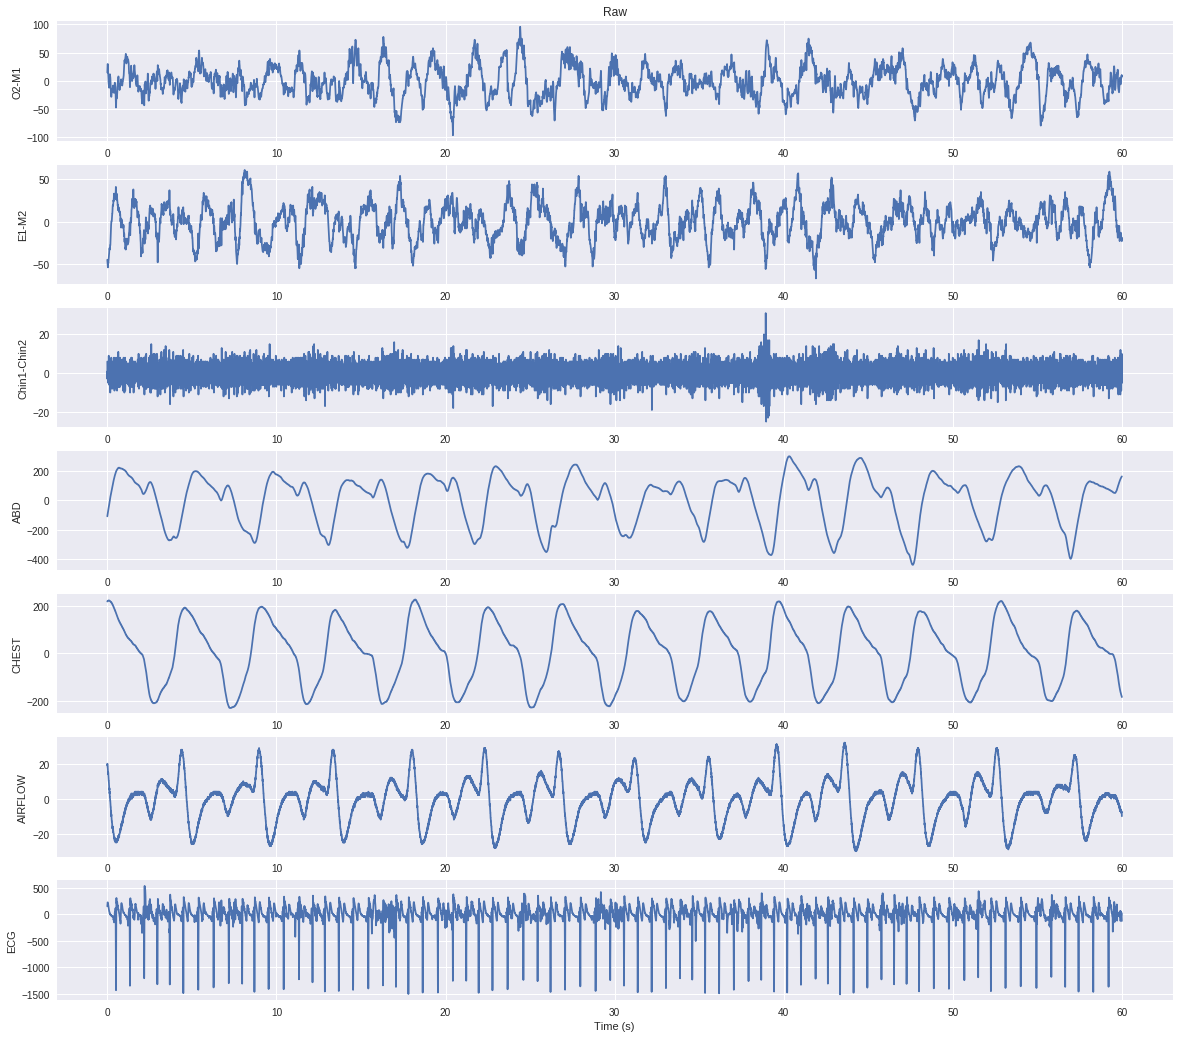

In [8]:
""" sample (pd dataframe) must be output from get_sample_data() """
def get_raw_signals(sample):
    raw_signals_x = np.arange(0, 60, step = 1/200)
    raw_signals_y = np.transpose(sample['Signal'][0])
    """ tuple: raw_signals_x (ndarray) stores raw signal timepoints in seconds; raw_signals_y (ndarray) stores all seven signals for every timepoint; 'Raw' (str) stores signal type """
    return (raw_signals_x, raw_signals_y, 'Raw')


""" signal_list (list) contains output (tuple) from get_raw_signals() """
def graph_signals(signal_list):
    num_type_signals = len(signal_list)
    plt.figure(figsize = (20, 18))
    for signal_format_index, signal_xy in enumerate(signal_list):
        for signal_index in range(7):
            plt.subplot(7, num_type_signals, num_type_signals*signal_index + signal_format_index + 1)
            if signal_index==0:
                plt.title(signal_xy[2])
            plt.plot(signal_xy[0], signal_xy[1][signal_index])
            plt.ylabel(sig_dict[signal_index])
        plt.xlabel(sig_type_dict[signal_format_index])
    plt.show()

""" Initalizes key reference dictionaries """
sig_dict = {0:'O2-M1', 1:'E1-M2', 2:'Chin1-Chin2', 3:'ABD', 4:'CHEST', 5:'AIRFLOW', 6:'ECG'}
sig_type_dict = {0:'Time (s)', 1:'Frequency (Hz)'}
stage_dict = {0:'Arousal', 1:'NREM1', 2:'NREM2', 3:'NREM3', 4:'REM'}


data_type = 'test'
sample, sample_id = get_sample_data(data_type, 65)  # change the second argument to visualize other test data sample
raw_signals = get_raw_signals(sample)
if data_type == 'training': 
    print(data_type.title(), sample_id, '(' + stage_dict[int(sample_id.split('.')[0])//800] + ')')
else: 
    print(data_type.title(), sample_id, '(Unknown)')
graph_signals([raw_signals])

## Example Classifier

Below is an example of a poor classifier for this dataset. It is a simple neural network that takes the maximal, normalized variance for each signal (given a frame and interval) as its input features. Obviously, this feature is not very good at classifying the data by itself. After training, it performs with 44% accuracy on test data.

While the example classifier makes use of a neural network, we encourage you to utilize any ML algorithm that you feel would be appropriate. Also, note that this example classifier makes use of only the raw signals, without consideration of the FFT signals or any other processed form of the raw signals.

In [0]:
# Defining functions to extract variance feature   
  
  
  #""" signals (ndarray) must be from index 1 of get_raw_signals(), get_fft_signals(), or get_signals(); frame (int) must be from 0-12000; interval (int) must be from 0-12000 """
def get_partial_features(signals, frame, interval):
    partial_array = np.ndarray(shape = (signals.shape[0], (signals.shape[1]-frame)//interval+1))
    for signal_index, signal in enumerate(signals):
        for partial_index in range((len(signal)-frame)//interval+1):
            
            partial_array[signal_index][partial_index] = np.var(signal[(interval*partial_index):(interval*partial_index)+frame])
     
    return partial_array

""" signals same as get_partial_features() input """
def consolidate_features(signals):
    total_array = np.ndarray(shape = (signals.shape[0], 1))
    for signal_index, signal in enumerate(signals):
        
        """ Change feature extraction here """
        if np.sum(signal)>0:
            total_array[signal_index] = int(np.max(signal)/np.sum(signal)*100)
        else:
            total_array[signal_index] = 0
            
    """ total_array (ndarray) stores single feature for each signal """
    return total_array

""" data_type (str) must be 'training' or 'test'; num_samples (int) must be 0-4000 for 'training' or 0-1000 for 'test' """
def get_features(data_type, num_samples):
    features, order = np.array([]), np.array([])
    for i in range(num_samples):
        sample, sample_id = get_sample_data(data_type, i)
        sample_raw = get_raw_signals(sample)
        sample_y_partial = get_partial_features(sample_raw[1], 200, 200)
        sample_y_consolidate = consolidate_features(sample_y_partial)
        features = np.hstack((features, sample_y_consolidate)) if features.size else sample_y_consolidate
        order = np.append(order, int(sample_id.split('.')[0]))
    """ np.transpose(features) (ndarray) stores final features for training/testing; order (ndarray) stores order in which samples were retrieved """
    return np.transpose(features), order

In [0]:
# Getting feature

train_data, train_order = get_features('training', 4000)
test_data, test_order = get_features('test', 1000)

In [0]:
# Converting from integer labels to one-hot labels

train_labels = np.ndarray(shape = (1, 4000))
for i in range(4000):
    train_labels[0][i] = i//800
train_labels = tf.keras.utils.to_categorical(train_labels[0], 5)
train_labels = train_labels.astype(np.float32)

In [0]:
# Making sure everything is type float32

train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)
train_labels = train_labels.astype(np.float32)

In [13]:
print(train_data.shape, train_labels.shape, '\n\n', train_data, '\n\n', train_labels)

(4000, 7) (4000, 5) 

 [[ 5.  6.  4. ... 21.  7.  2.]
 [25.  9.  1. ... 19. 11.  2.]
 [ 9.  9.  3. ...  7.  5.  2.]
 ...
 [ 4. 28.  2. ... 10.  1.  2.]
 [12. 26.  2. ...  8.  1.  2.]
 [11. 25.  4. ... 10.  1.  2.]] 

 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [0]:
# Shuffling data and splitting training data into train, validation, and mock test (mock test data is not required but can be useful to have)

train_data, train_labels = shuffle(train_data, train_labels)

""" val_size (int) must be from 0-4000 """
val_size = 1000
mocktest_size = 500

val_data = train_data[:val_size]
mocktest_data = train_data[val_size:val_size + mocktest_size]
partial_train_data = train_data[val_size + mocktest_size:]

val_labels = train_labels[:val_size]
mocktest_labels = train_labels[val_size:val_size + mocktest_size]
partial_train_labels = train_labels[val_size + mocktest_size:]

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.shuffle(partial_train_labels.shape[0]).batch(40)

In [15]:
# Building network

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))
model.compile(loss='categorical_crossentropy', optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 4,997
Trainable params: 4,997
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Training Network

""" EPOCHS (int) is whatever number causes stabilization of validation loss and accuracy """
EPOCHS = 50

for epoch in range(EPOCHS):
    for signals, labels in training_set:
        tr_loss, tr_accuracy = model.train_on_batch(signals, labels)
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)
    print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
         'Validation Loss: %.2f\tValidation Accuracy: %.2f')
         % (epoch + 1, tr_loss, tr_accuracy,
         val_loss, val_accuracy))

1000/1000 [==============================] - 0s 48us/step
Epoch #1	 Training Loss: 1.72	Training Accuracy: 0.40	Validation Loss: 1.68	Validation Accuracy: 0.34
1000/1000 [==============================] - 0s 48us/step
Epoch #2	 Training Loss: 1.45	Training Accuracy: 0.45	Validation Loss: 1.58	Validation Accuracy: 0.36
1000/1000 [==============================] - 0s 48us/step
Epoch #3	 Training Loss: 1.52	Training Accuracy: 0.25	Validation Loss: 1.51	Validation Accuracy: 0.40
1000/1000 [==============================] - 0s 49us/step
Epoch #4	 Training Loss: 1.26	Training Accuracy: 0.40	Validation Loss: 1.52	Validation Accuracy: 0.37
1000/1000 [==============================] - 0s 48us/step
Epoch #5	 Training Loss: 1.84	Training Accuracy: 0.25	Validation Loss: 1.49	Validation Accuracy: 0.42
1000/1000 [==============================] - 0s 48us/step
Epoch #6	 Training Loss: 1.54	Training Accuracy: 0.40	Validation Loss: 1.45	Validation Accuracy: 0.43
1000/1000 [=============================

## Submitting Your Model

After training your classifier, run it on the test data to generate your predictions. Each class for a test sample should have an associated probability (between 0 and 1). Below are the parameters for the prediction format and export:

- Your predictions should be in a pandas dataframe with 5 columns (classes) and 1000 rows (samples). Note that your predictions must follow the original test sample order (0.xz, 1.xz, 2.xz, ...). You only need to worry about this if you shuffled the test samples or stored the samples in an unordered data structure (dictionaries and sets). If this is the case, you should 1) add a separate column in your pandas dataframe with the file number for each sample; 2) sort the dataframe using this column; and 3) drop the column. These steps have been noted in the code below.
- The predictions dataframe should be exported as an .xz file using dataframe.to_pickle() followed by files.download().

Example code of the prediction format and export is presented in the cell block below. 

In [17]:
### Run once after you have finished training your model ###

test_pred = model.predict(test_data)
test_output = np.ndarray(shape = (1000, 6))

""" Add column with file number """
for i in range(1000):
    test_output[i] = np.append(test_pred[i], test_order[i])
test_dataframe = pd.DataFrame(test_output)

""" Sort dataframe according to file number """
sorted_test_dataframe = test_dataframe.sort_values(by=[5])

""" Drop file number column """
processed_test_dataframe = sorted_test_dataframe.drop(sorted_test_dataframe.columns[5], axis=1)

print(test_dataframe.head(), '\n\n', sorted_test_dataframe.head(), '\n\n', processed_test_dataframe.head())

file = 'PotatoesAreGreat.xz'
processed_test_dataframe.to_pickle(file)
files.download(file)

          0         1         2         3         4    5
0  0.018165  0.215468  0.235739  0.438796  0.091833  0.0
1  0.119147  0.306955  0.180577  0.311649  0.081673  1.0
2  0.133334  0.467366  0.122358  0.178165  0.098776  2.0
3  0.038705  0.108846  0.183076  0.574953  0.094420  3.0
4  0.564470  0.171024  0.149196  0.081974  0.033336  4.0 

           0         1         2         3         4    5
0  0.018165  0.215468  0.235739  0.438796  0.091833  0.0
1  0.119147  0.306955  0.180577  0.311649  0.081673  1.0
2  0.133334  0.467366  0.122358  0.178165  0.098776  2.0
3  0.038705  0.108846  0.183076  0.574953  0.094420  3.0
4  0.564470  0.171024  0.149196  0.081974  0.033336  4.0 

           0         1         2         3         4
0  0.018165  0.215468  0.235739  0.438796  0.091833
1  0.119147  0.306955  0.180577  0.311649  0.081673
2  0.133334  0.467366  0.122358  0.178165  0.098776
3  0.038705  0.108846  0.183076  0.574953  0.094420
4  0.564470  0.171024  0.149196  0.081974  0.03333

Your model will be evaluated on Area Under the ROC Curve (ROCAUC), Matthews Correlation Coefficient (MCC) and creativity. There will be a "winning" group for each of these categories.

If you are finished early, consider trying other ML algorithms and/or implementing multiple feature extraction methods. You can also help other groups if you finish early.

## How Your Model Will Be Evaluated

- **Area Under the ROC Curve (AUCROC)**: The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." Below is the multi-class ROC curve for the example classifier. The AUCROC score should be between 0 and 1, in which 0.5 is random classification and 1 is perfect classification.

 ![alt text](https://image.ibb.co/g4pzST/ROCAUC.png)

- **Matthews Correlation Coefficient (MCC)**: The MCC measures the quality of binary classifications, irrespective of the class sizes. Importantly, it is typically regarded as a balanced measure since it considers all values in the 2x2 contingency table (TP, FP, TN, FN). For this challenge, the binary classes will be "Arousal" (Arousal) and "Nonarousal" (NREM1, NREM2, NREM3, REM). The MCC score should be between -1 and 1, in which 0 is random classification and 1 is perfect classification.

 ![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

Using these metrics, the example classifier has the following scores on test data:
- AUCROC: 0.755
- MCC: 0.353
- Creativity: ( ͡° ͜ʖ ͡°)

Below is the code used to calculate the AUCROC and MCC metrics when evaluating your classifier.

In [0]:
test_pred = pd.DataFrame(model.predict(mocktest_data))
test_predict = test_pred.idxmax(axis=1)
test_labels = [ np.where(label==1)[0][0] for label in mocktest_labels]
test_labels_one_hot = pd.DataFrame(mocktest_labels)

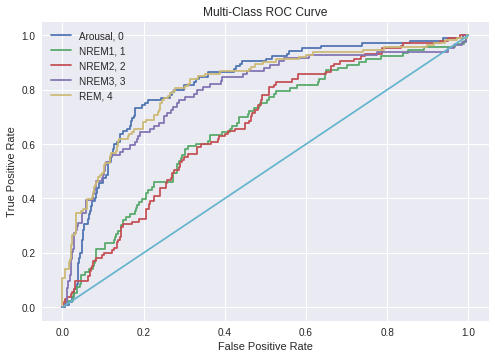

In [20]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc = metrics.auc(fpr["micro"], tpr["micro"])

In [0]:
y_true = []
y_pred = []
for i in range(test_pred.shape[0]):
    if test_predict.iloc[i]==0: y_pred.append(1)
    else: y_pred.append(-1)
    if test_labels[i]==0: y_true.append(1)
    else: y_true.append(-1)
mcc = metrics.matthews_corrcoef(y_true, y_pred)

In [22]:
print(roc_auc, mcc)

0.743266 0.4378565138452206
